In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



In [ ]:
transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/takehome_ds_written.csv')

### Data Quality Check and Cleaning

In [ ]:
def clean(transactions):
  #changing price in dollars
  transactions['price_in_dollars']=transactions['amount_usd_in_cents']/100
  transactions.drop(columns=['amount_usd_in_cents','Unnamed: 0'], axis=1, inplace = True)

  #changing dtype of time from object to datetime
  transactions.rename(columns={'time': 'date_time'}, inplace=True)
  transactions['date_time'] = pd.to_datetime(transactions['date_time'])
  # transactions['merchant'] = transactions['merchant'].astype('string')

clean(transactions)


In [ ]:
transactions

,merchant,date_time,price_in_dollars
0,faa029c6b0,2034-06-17 23:34:14,63.49
1,ed7a7d91aa,2034-12-27 00:40:38,38.54
2,5608f200cf,2034-04-30 01:29:42,7.89
3,15b1a0d61e,2034-09-16 01:06:23,44.52
4,4770051790,2034-07-22 16:21:42,202.03
...,...,...,...
1513714,72d37bedbf,2034-06-21 13:47:51,52.74
1513715,5608f200cf,2034-04-20 02:23:59,7.54
1513716,fcbd1dae68,2033-09-19 14:02:33,132.03
1513717,9843e52410,2034-12-28 20:07:59,48.45


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513719 entries, 0 to 1513718
Data columns (total 3 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   merchant          1513719 non-null  object        
 1   date_time         1513719 non-null  datetime64[ns]
 2   price_in_dollars  1513719 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 34.6+ MB


In [ ]:
#check if there's null
transactions.isnull().sum()

merchant            0
date_time           0
price_in_dollars    0
dtype: int64

In [ ]:
#checking for consistency if it's really 2 years
print((transactions['date_time'].max()-transactions['date_time'].min()))
print(transactions['date_time'].min())

728 days 22:21:08
2033-01-01 09:38:32


### EDA and Data Wrangling

Merchant analysis

1. Active - Most number of transactions
  - Highly Active - First Quantile
  - Active - 2nd Quantile
  - Inactive - 3rd Percentile
  - Highly Inactive - 4th Quantile excluding zero
2. Value - Rate of  price per transaction
  - High Value - First Quantile
  - Value - 3rd Percentile
  - Low Value - 3rd Percentile
  - Very Low Value - 4th Percentile

In [ ]:
transactions['total_transactions'] = transactions.groupby('merchant')['merchant'].transform('count')

# group the transactions by merchant and calculate total number of transactions and total price
merchant = transactions.groupby('merchant').agg({'date_time': 'count', 'price_in_dollars': 'sum'})
# rename the columns to 'num_transactions' and 'total_price'
merchant.rename(columns={'time': 'num_transactions', 'price_in_dollars': 'total_price'}, inplace=True)
# summary_df = summary_df.sort_values('num_transactions', ascending=False)
merchant.rename(columns={'date_time': 'number_of_transaction'}, inplace=True)
merchant_sales = merchant.sort_values('number_of_transaction', ascending=False).reset_index()
merchant_sales

,merchant,number_of_transaction,total_price
0,5608f200cf,25512,209115.71
1,53b3fbeae2,12178,607337.40
2,1ddaea9838,12042,414435.45
3,89e2d29885,11969,180545.00
4,654930c922,11222,1511162.95
...,...,...,...
14346,9847b12953,1,108.15
14347,985bf67891,1,19.33
14348,9865dca5a3,1,13128.20
14349,988269b4df,1,401.45


In [ ]:
merchant_sales['rate_sale'] = merchant_sales['total_price']/merchant_sales['number_of_transaction']
merchant_sales

,merchant,number_of_transaction,total_price,rate_sale
0,5608f200cf,25512,209115.71,8.196759
1,53b3fbeae2,12178,607337.40,49.871687
2,1ddaea9838,12042,414435.45,34.415832
3,89e2d29885,11969,180545.00,15.084385
4,654930c922,11222,1511162.95,134.660751
...,...,...,...,...
14346,9847b12953,1,108.15,108.150000
14347,985bf67891,1,19.33,19.330000
14348,9865dca5a3,1,13128.20,13128.200000
14349,988269b4df,1,401.45,401.450000


In [ ]:
# Create a copy of the transactions table
merchants = transactions.copy()

# Add new columns for day of week and month of year
merchants['day_of_week'] = merchants['date_time'].dt.day_name()
merchants['month_of_year'] = merchants['date_time'].dt.month_name()

# Group by merchant, day of week, and month of year to get transaction count
merchant_count = merchants.groupby(['merchant', 'day_of_week', 'month_of_year'])['price_in_dollars'].count().reset_index()

# Get the index of the row with the highest transaction count for each merchant
idx = merchant_count.groupby(['merchant'])['price_in_dollars'].transform(max) == merchant_count['price_in_dollars']

# Create a new dataframe with unique merchants and their highest transaction day of week and month of year
highest_trans_days = merchant_count[idx][['merchant', 'day_of_week', 'month_of_year']]

# Rename the columns to indicate the highest transaction day of week and month of year
highest_trans_days = highest_trans_days.rename(columns={'day_of_week': 'highest_transaction_day_of_week', 
                                                        'month_of_year': 'highest_transaction_month_of_year'})

# Create a table of all unique merchants
unique_merchants = merchants[['merchant']].drop_duplicates()

# Merge the highest transaction day of week and month of year table with the unique merchants table
unique_merchants = unique_merchants.merge(highest_trans_days, on='merchant', how='left')

# Print the final table of unique merchants with highest transaction day of week and month of year
unique_merchants = unique_merchants.drop_duplicates(subset='merchant')
unique_merchants


,merchant,highest_transaction_day_of_week,highest_transaction_month_of_year
0,faa029c6b0,Saturday,September
2,ed7a7d91aa,Sunday,December
6,5608f200cf,Sunday,July
7,15b1a0d61e,Friday,December
8,4770051790,Sunday,July
...,...,...,...
26781,41f6054841,Saturday,March
26782,cce748c02b,Monday,August
26783,9506efbbbd,Wednesday,November
26784,7dd807a637,Tuesday,December


In [ ]:
unique_merchants

,merchant,highest_transaction_day_of_week,highest_transaction_month_of_year
0,faa029c6b0,Saturday,September
2,ed7a7d91aa,Sunday,December
6,5608f200cf,Sunday,July
7,15b1a0d61e,Friday,December
8,4770051790,Sunday,July
...,...,...,...
26781,41f6054841,Saturday,March
26782,cce748c02b,Monday,August
26783,9506efbbbd,Wednesday,November
26784,7dd807a637,Tuesday,December


In [ ]:
merged_data = pd.merge(merchant_sales, unique_merchants, on='merchant', how='outer')

In [ ]:
merged_data

,merchant,number_of_transaction,total_price,rate_sale,highest_transaction_day_of_week,highest_transaction_month_of_year
0,5608f200cf,25512,209115.71,8.196759,Sunday,July
1,53b3fbeae2,12178,607337.40,49.871687,Saturday,December
2,1ddaea9838,12042,414435.45,34.415832,Friday,September
3,89e2d29885,11969,180545.00,15.084385,Friday,September
4,654930c922,11222,1511162.95,134.660751,Wednesday,January
...,...,...,...,...,...,...
14346,9847b12953,1,108.15,108.150000,Wednesday,September
14347,985bf67891,1,19.33,19.330000,Tuesday,December
14348,9865dca5a3,1,13128.20,13128.200000,Thursday,November
14349,988269b4df,1,401.45,401.450000,Friday,June


In [ ]:
# quartiles = pd.qcut(merged_data['rate_sale'], q=4, labels=['Very Low Value', 'Low Value', 'Value', 'High Value'])

# # Define a mapping of quartile labels to new values
# new_values = {'Very Low Value': 'Very Low Value', 'Low Value': 'Low Value', 'Value': 'Value', 'High Value': 'High Value'}

# # Map the quartile labels to the new values and store in a new column
# merged_data['rate_sale'] = quartiles.map(new_values)

In [ ]:
# quartiles = pd.qcut(merged_data['number_of_transaction'], q=4, labels=['Highly Inactive', 'Inactive', 'Active', 'Highly Active'])

# # Define a mapping of quartile labels to new values
# new_values = {'Highly Inactive': 'Highly Inactive', 'Inactive': 'Inactive', 'Active': 'Active', 'Highly Active': 'Highly Active'}

# # Map the quartile labels to the new values and store in a new column
# merged_data['number_of_transaction'] = quartiles.map(new_values)

In [ ]:
merged_data

,merchant,number_of_transaction,total_price,rate_sale,highest_transaction_day_of_week,highest_transaction_month_of_year
0,5608f200cf,25512,209115.71,8.196759,Sunday,July
1,53b3fbeae2,12178,607337.40,49.871687,Saturday,December
2,1ddaea9838,12042,414435.45,34.415832,Friday,September
3,89e2d29885,11969,180545.00,15.084385,Friday,September
4,654930c922,11222,1511162.95,134.660751,Wednesday,January
...,...,...,...,...,...,...
14346,9847b12953,1,108.15,108.150000,Wednesday,September
14347,985bf67891,1,19.33,19.330000,Tuesday,December
14348,9865dca5a3,1,13128.20,13128.200000,Thursday,November
14349,988269b4df,1,401.45,401.450000,Friday,June


<Axes: xlabel='highest_transaction_day_of_week', ylabel='count'>

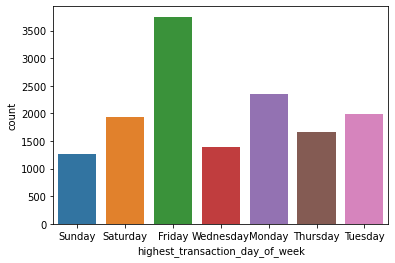

In [ ]:
sns.countplot(data=merged_data, x='highest_transaction_day_of_week')


In [ ]:
merged_data['highest_transaction_day_of_week'].value_counts()

Friday       3751
Monday       2351
Tuesday      1990
Saturday     1944
Thursday     1659
Wednesday    1394
Sunday       1262
Name: highest_transaction_day_of_week, dtype: int64

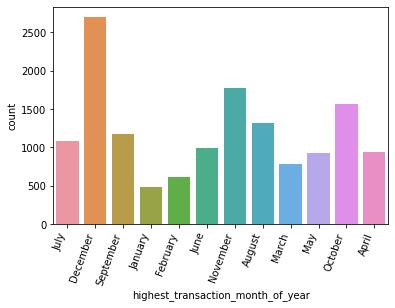

In [ ]:
import matplotlib.pyplot as plt
ax = sns.countplot(data=merged_data, x='highest_transaction_month_of_year')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
plt.show()

In [ ]:
pd.DataFrame(merged_data['highest_transaction_month_of_year'].value_counts())

,highest_transaction_month_of_year
December,2702
November,1771
October,1569
August,1315
September,1172
July,1080
June,997
April,935
May,928
March,785


## Churn Analysis

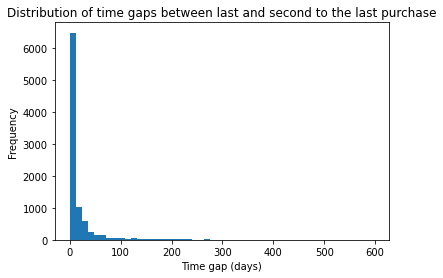

In [ ]:
import matplotlib.pyplot as plt

# Group the transactions by merchant
grouped = transactions.groupby('merchant')

# Calculate the time gap between last and second to the last purchase for each merchant
time_gaps = []
for name, group in grouped:
    if len(group) > 5:
        last_purchase = group['date_time'].max()
        second_last_purchase = group['date_time'].sort_values().iloc[-2]
        time_gap = (last_purchase - second_last_purchase).days
        time_gaps.append(time_gap)

# Create a histogram of the time gaps
plt.hist(time_gaps, bins=50)
plt.xlabel('Time gap (days)')
plt.ylabel('Frequency')
plt.title('Distribution of time gaps between last and second to the last purchase')
plt.show()


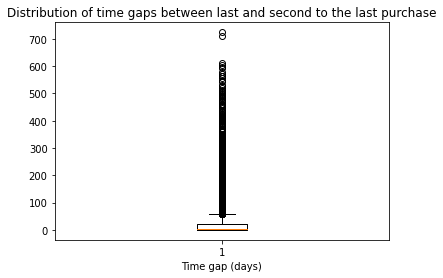

In [ ]:
grouped = transactions.groupby('merchant')

# Calculate the time gap between last and second to the last purchase for each merchant
time_gaps = []
for name, group in grouped:
    if len(group) > 1:
        last_purchase = group['date_time'].max()
        second_last_purchase = group['date_time'].sort_values().iloc[-2]
        time_gap = (last_purchase - second_last_purchase).days
        time_gaps.append(time_gap)

# Create a boxplot of the time gaps
plt.boxplot(time_gaps)
plt.xlabel('Time gap (days)')
plt.title('Distribution of time gaps between last and second to the last purchase')
plt.show()

In [ ]:
df1 = transactions.copy()

# Group transactions by merchant
merchant_grouped = df1.groupby('merchant')

# Calculate the time difference between the last and second to last purchase for each merchant
time_diffs = merchant_grouped.apply(lambda x: x.sort_values('date_time')['date_time'].diff(periods=2).iloc[-1])

# Filter out merchants with less than 5 transactions
merchant_counts = merchant_grouped.size()
valid_merchants = merchant_counts[merchant_counts >= 5].index
time_diffs = time_diffs[time_diffs.index.isin(valid_merchants)]

# Calculate the average time gap between last and second to last purchase for each merchant
avg_time_gap = time_diffs.mean()

print(f"Average time gap between last and second to last purchase for each merchant: {avg_time_gap}")


Average time gap between last and second to last purchase for each merchant: 35 days 03:23:00.390824563


In [ ]:
# Filter the transactions table to only include merchants with more than one transaction
merchant_counts = transactions['merchant'].value_counts()
df_filtered = transactions[transactions['merchant'].isin(merchant_counts[merchant_counts > 5].index)]

# Group transactions by merchant, and calculate the time difference between the last and second to last purchase
time_diff = df_filtered.groupby('merchant')['date_time'].diff(periods=2)

# Calculate the mean of the time differences for each merchant
mean_time_diff = pd.DataFrame(time_diff.groupby(df_filtered['merchant']).mean())
mean_time_diff['date_time'].mean()

Timedelta('0 days 07:35:56.738175673')

In [ ]:
df = transactions.copy() 
# Convert the 'time' column to a datetime object

# Set the 'time' column as the index
df = df.set_index('date_time')

In [ ]:
# Group the data by customer and month and compute the total revenue for each month
monthly_revenue = df.groupby([pd.Grouper(freq='M'), 'merchant']).sum()

# Reset the index to a standard DataFrame format
monthly_revenue = monthly_revenue.reset_index()

In [ ]:
# Get the most recent month in the dataset
last_month = monthly_revenue['date_time'].max()

# Create a boolean mask for customers who made a purchase in the last month
active_customers = monthly_revenue[monthly_revenue['date_time'] == last_month]['merchant'].unique()

In [ ]:
# Create a DataFrame of all customers and the month of their last purchase
last_purchase = monthly_revenue.groupby('merchant')['date_time'].max().reset_index()
last_purchase.columns = ['merchant', 'last_purchase']

# Calculate the number of months since the customer's last purchase
last_purchase['months_since_last_purchase'] = (last_month - last_purchase['last_purchase']) / pd.Timedelta(days=30)

# Create a boolean mask for churned customers
churned_customers = last_purchase[last_purchase['months_since_last_purchase'] >= 1]['merchant'].unique()


In [ ]:
# Calculate the total number of customers in the dataset
total_customers = monthly_revenue['merchant'].nunique()

# Calculate the number of churned customers
churned_count = len(churned_customers)

# Calculate the churn rate as a percentage
churn_rate = churned_count / total_customers * 100

print(f"Churn rate: {churn_rate:.2f}%")


Churn rate: 57.31%


In [ ]:
churned_customers = pd.DataFrame(churned_customers)

In [ ]:
churned_customers = churned_customers.assign(churn_status='churned')

In [ ]:
churned_customers = churned_customers.rename(columns={0: 'merchant'})


In [ ]:
churned_customers

,merchant,churn_status
0,0002b63b92,churned
1,00057d4302,churned
2,000bcff341,churned
3,000ddbf0ca,churned
4,001f7b7a4f,churned
...,...,...
8220,ffc5a319bb,churned
8221,ffd3e45675,churned
8222,ffe1f6b51a,churned
8223,ffe26b900d,churned


In [ ]:
merged_data = merged_data.merge(churned_customers, on='merchant', how='left')



In [ ]:
# # create a function to check if merchant is churned or non-churn
# def check_churned(merchant, churned_customers):
#     if merchant in churned_customers['churn_status']:
#         return 'churned'
#     else:
#         return 'non-churn'

# # apply the check_churned function to create a new column 'churn_status'
# merged_data['churn_status'] = merged_data['merchant'].apply(lambda x: check_churned(x, churned_customers))


In [ ]:
merged_data

,merchant,number_of_transaction,total_price,rate_sale,highest_transaction_day_of_week,highest_transaction_month_of_year,churn_status
0,5608f200cf,25512,209115.71,8.196759,Sunday,July,NaN
1,53b3fbeae2,12178,607337.40,49.871687,Saturday,December,NaN
2,1ddaea9838,12042,414435.45,34.415832,Friday,September,NaN
3,89e2d29885,11969,180545.00,15.084385,Friday,September,NaN
4,654930c922,11222,1511162.95,134.660751,Wednesday,January,NaN
...,...,...,...,...,...,...,...
14346,9847b12953,1,108.15,108.150000,Wednesday,September,churned
14347,985bf67891,1,19.33,19.330000,Tuesday,December,NaN
14348,9865dca5a3,1,13128.20,13128.200000,Thursday,November,churned
14349,988269b4df,1,401.45,401.450000,Friday,June,churned


In [ ]:
merged_data['churn_status'] = merged_data['churn_status'].fillna('Not churn')

In [ ]:
merged_data['churn_status'].value_counts()
merged_data = merged_data.set_index(df.columns[0])
merged_data

,number_of_transaction,total_price,rate_sale,highest_transaction_day_of_week,highest_transaction_month_of_year,churn_status
merchant,,,,,,
5608f200cf,25512,209115.71,8.196759,Sunday,July,Not churn
53b3fbeae2,12178,607337.40,49.871687,Saturday,December,Not churn
1ddaea9838,12042,414435.45,34.415832,Friday,September,Not churn
89e2d29885,11969,180545.00,15.084385,Friday,September,Not churn
654930c922,11222,1511162.95,134.660751,Wednesday,January,Not churn
...,...,...,...,...,...,...
9847b12953,1,108.15,108.150000,Wednesday,September,churned
985bf67891,1,19.33,19.330000,Tuesday,December,Not churn
9865dca5a3,1,13128.20,13128.200000,Thursday,November,churned


In [ ]:
merged_data['churn_status'].value_counts()

churned      8225
Not churn    6126
Name: churn_status, dtype: int64

In [ ]:
X = merged_data.drop('churn_status', axis=1)
y = merged_data['churn_status']

In [ ]:
X

,number_of_transaction,total_price,rate_sale,highest_transaction_day_of_week,highest_transaction_month_of_year
merchant,,,,,
5608f200cf,25512,209115.71,8.196759,Sunday,July
53b3fbeae2,12178,607337.40,49.871687,Saturday,December
1ddaea9838,12042,414435.45,34.415832,Friday,September
89e2d29885,11969,180545.00,15.084385,Friday,September
654930c922,11222,1511162.95,134.660751,Wednesday,January
...,...,...,...,...,...
9847b12953,1,108.15,108.150000,Wednesday,September
985bf67891,1,19.33,19.330000,Tuesday,December
9865dca5a3,1,13128.20,13128.200000,Thursday,November


In [ ]:
one_hot_encoded = pd.get_dummies(X, ['highest_transaction_day_of_week','highest_transaction_month_of_year'])

# concatenate the original dataframe and the one-hot encoded dataframe
X = pd.concat([X, one_hot_encoded], axis=1)

# delete the original column
X.drop(['highest_transaction_day_of_week','highest_transaction_month_of_year'], axis=1, inplace=True)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# # fit the scaler to the dataframe and transform the data
# scaled_data = scaler.fit_transform(X[['number_of_transaction', 'total_price', 'number_of_transaction','total_price','rate_sale']])

# # create a new dataframe with the scaled data
# scaled_df = pd.DataFrame(scaled_data, columns=['number_of_transaction', 'total_price', 'number_of_transaction','total_price','rate_sale'])

# # concatenate the original dataframe and the scaled dataframe
# X = pd.concat([X, scaled_df], axis=1)

from sklearn.preprocessing import StandardScaler

# create a StandardScaler object
scaler = StandardScaler()

# fit and transform the selected columns
columns_to_scale = ['total_price', 'number_of_transaction','rate_sale']
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
# X.drop(columns = ['total_price', 'number_of_transaction','total_price','rate_sale'], axis=1, inplace=True)

# print the standardized dataframe
X

,number_of_transaction,total_price,rate_sale,number_of_transaction,total_price,rate_sale,highest_transaction_day_of_week_Friday,highest_transaction_day_of_week_Monday,highest_transaction_day_of_week_Saturday,highest_transaction_day_of_week_Sunday,...,highest_transaction_month_of_year_December,highest_transaction_month_of_year_February,highest_transaction_month_of_year_January,highest_transaction_month_of_year_July,highest_transaction_month_of_year_June,highest_transaction_month_of_year_March,highest_transaction_month_of_year_May,highest_transaction_month_of_year_November,highest_transaction_month_of_year_October,highest_transaction_month_of_year_September
merchant,,,,,,,,,,,,,,,,,,,,,
5608f200cf,48.145806,2.997476,-0.263472,48.145806,2.997476,-0.263472,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
53b3fbeae2,22.877641,9.189214,-0.234023,22.877641,9.189214,-0.234023,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1ddaea9838,22.619919,6.189884,-0.244944,22.619919,6.189884,-0.244944,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
89e2d29885,22.481583,2.553246,-0.258605,22.481583,2.553246,-0.258605,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
654930c922,21.066004,23.242316,-0.174107,21.066004,23.242316,-0.174107,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847b12953,-0.197988,-0.252271,-0.192841,-0.197988,-0.252271,-0.192841,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
985bf67891,-0.197988,-0.253652,-0.255605,-0.197988,-0.253652,-0.255605,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9865dca5a3,-0.197988,-0.049829,9.007718,-0.197988,-0.049829,9.007718,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
X

,number_of_transaction,total_price,rate_sale,number_of_transaction,total_price,rate_sale,highest_transaction_day_of_week_Friday,highest_transaction_day_of_week_Monday,highest_transaction_day_of_week_Saturday,highest_transaction_day_of_week_Sunday,...,highest_transaction_month_of_year_December,highest_transaction_month_of_year_February,highest_transaction_month_of_year_January,highest_transaction_month_of_year_July,highest_transaction_month_of_year_June,highest_transaction_month_of_year_March,highest_transaction_month_of_year_May,highest_transaction_month_of_year_November,highest_transaction_month_of_year_October,highest_transaction_month_of_year_September
merchant,,,,,,,,,,,,,,,,,,,,,
5608f200cf,48.145806,2.997476,-0.263472,48.145806,2.997476,-0.263472,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
53b3fbeae2,22.877641,9.189214,-0.234023,22.877641,9.189214,-0.234023,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1ddaea9838,22.619919,6.189884,-0.244944,22.619919,6.189884,-0.244944,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
89e2d29885,22.481583,2.553246,-0.258605,22.481583,2.553246,-0.258605,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
654930c922,21.066004,23.242316,-0.174107,21.066004,23.242316,-0.174107,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847b12953,-0.197988,-0.252271,-0.192841,-0.197988,-0.252271,-0.192841,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
985bf67891,-0.197988,-0.253652,-0.255605,-0.197988,-0.253652,-0.255605,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9865dca5a3,-0.197988,-0.049829,9.007718,-0.197988,-0.049829,9.007718,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report

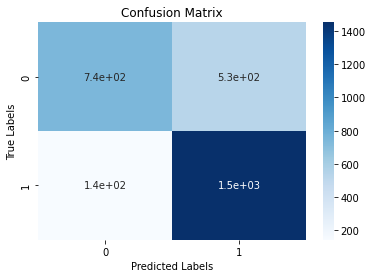

              precision    recall  f1-score   support

   Not churn       0.84      0.58      0.69      1275
     churned       0.73      0.91      0.81      1596

    accuracy                           0.76      2871
   macro avg       0.78      0.75      0.75      2871
weighted avg       0.78      0.76      0.76      2871



In [ ]:
import seaborn as sns

# Fit a logistic regression model to the training data
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = lr.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix heatmap
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Generate the classification report
print(classification_report(y_test, y_pred))
